# Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter

# Set Seeds for Reproducibility

In [2]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [3]:
# Data transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [7]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [8]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [9]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [10]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [11]:
def create_vit_model(num_classes=4, pretrained=True, model_type='b16'):
    """
    Create Vision Transformer model for multi-class classification
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
        model_type (str): Type of ViT model - 'b16' or 'b32'
    
    Returns:
        model: Vision Transformer model
    """
    if model_type.lower() == 'b16':
        model = models.vit_b_16(pretrained=pretrained)
    elif model_type.lower() == 'b32':
        model = models.vit_b_32(pretrained=pretrained)
    else:
        raise ValueError(f"Invalid model_type: {model_type}. Choose 'b16' or 'b32'")
    
    # Modify the classifier head for our number of classes
    num_features = model.heads.head.in_features
    model.heads.head = nn.Linear(num_features, num_classes)
    
    return model

# Configure GPU

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [13]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [14]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train ViT-B/16

Training Vision Transformer B/16


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:18<00:00, 18.6MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:25<00:00,  1.52it/s, Loss=1.4974, Acc=0.3298]


Train Loss: 1.4974 Acc: 0.3298 Macro-F1: 0.3037


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=1.3123, Acc=0.4474]


Val Loss: 1.3123 Acc: 0.4474 Macro-F1: 0.3179
✓ New best model saved with validation macro-F1: 0.3179

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.59it/s, Loss=1.2686, Acc=0.3758]


Train Loss: 1.2686 Acc: 0.3758 Macro-F1: 0.3408


Val : 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Loss=1.0957, Acc=0.4868]


Val Loss: 1.0957 Acc: 0.4868 Macro-F1: 0.4060
✓ New best model saved with validation macro-F1: 0.4060

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.58it/s, Loss=1.2545, Acc=0.4186]


Train Loss: 1.2545 Acc: 0.4186 Macro-F1: 0.3816


Val : 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, Loss=1.2511, Acc=0.3816]


Val Loss: 1.2511 Acc: 0.3816 Macro-F1: 0.3124

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.57it/s, Loss=1.2571, Acc=0.4038]


Train Loss: 1.2571 Acc: 0.4038 Macro-F1: 0.3769


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=1.0717, Acc=0.5033]


Val Loss: 1.0717 Acc: 0.5033 Macro-F1: 0.4553
✓ New best model saved with validation macro-F1: 0.4553

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.57it/s, Loss=1.1641, Acc=0.4622]


Train Loss: 1.1641 Acc: 0.4622 Macro-F1: 0.4364


Val : 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Loss=1.0531, Acc=0.5296]


Val Loss: 1.0531 Acc: 0.5296 Macro-F1: 0.4647
✓ New best model saved with validation macro-F1: 0.4647

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=1.1605, Acc=0.4901]


Train Loss: 1.1605 Acc: 0.4901 Macro-F1: 0.4588


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=1.0630, Acc=0.5559]


Val Loss: 1.0630 Acc: 0.5559 Macro-F1: 0.5153
✓ New best model saved with validation macro-F1: 0.5153

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=1.1372, Acc=0.5082]


Train Loss: 1.1372 Acc: 0.5082 Macro-F1: 0.4736


Val : 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Loss=1.2320, Acc=0.4507]


Val Loss: 1.2320 Acc: 0.4507 Macro-F1: 0.4165

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=1.0684, Acc=0.5304]


Train Loss: 1.0684 Acc: 0.5304 Macro-F1: 0.5016


Val : 100%|██████████| 10/10 [00:02<00:00,  4.43it/s, Loss=0.9098, Acc=0.5822]


Val Loss: 0.9098 Acc: 0.5822 Macro-F1: 0.5499
✓ New best model saved with validation macro-F1: 0.5499

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.9968, Acc=0.5691]


Train Loss: 0.9968 Acc: 0.5691 Macro-F1: 0.5318


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=0.9010, Acc=0.5822]


Val Loss: 0.9010 Acc: 0.5822 Macro-F1: 0.5522
✓ New best model saved with validation macro-F1: 0.5522

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.9579, Acc=0.5888]


Train Loss: 0.9579 Acc: 0.5888 Macro-F1: 0.5566


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=0.9191, Acc=0.5526]


Val Loss: 0.9191 Acc: 0.5526 Macro-F1: 0.5245

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.9240, Acc=0.5970]


Train Loss: 0.9240 Acc: 0.5970 Macro-F1: 0.5666


Val : 100%|██████████| 10/10 [00:02<00:00,  4.34it/s, Loss=0.8414, Acc=0.6118]


Val Loss: 0.8414 Acc: 0.6118 Macro-F1: 0.5836
✓ New best model saved with validation macro-F1: 0.5836

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.9236, Acc=0.6110]


Train Loss: 0.9236 Acc: 0.6110 Macro-F1: 0.5755


Val : 100%|██████████| 10/10 [00:02<00:00,  4.33it/s, Loss=0.7859, Acc=0.6283]


Val Loss: 0.7859 Acc: 0.6283 Macro-F1: 0.5976
✓ New best model saved with validation macro-F1: 0.5976

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.8830, Acc=0.6151]


Train Loss: 0.8830 Acc: 0.6151 Macro-F1: 0.5821


Val : 100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Loss=0.8361, Acc=0.6184]


Val Loss: 0.8361 Acc: 0.6184 Macro-F1: 0.5913

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.8631, Acc=0.6299]


Train Loss: 0.8631 Acc: 0.6299 Macro-F1: 0.5937


Val : 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Loss=0.8620, Acc=0.6118]


Val Loss: 0.8620 Acc: 0.6118 Macro-F1: 0.5774

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.8373, Acc=0.6340]


Train Loss: 0.8373 Acc: 0.6340 Macro-F1: 0.5968


Val : 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Loss=0.8271, Acc=0.6217]


Val Loss: 0.8271 Acc: 0.6217 Macro-F1: 0.5874

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7984, Acc=0.6752]


Train Loss: 0.7984 Acc: 0.6752 Macro-F1: 0.6414


Val : 100%|██████████| 10/10 [00:02<00:00,  4.45it/s, Loss=0.8055, Acc=0.6250]


Val Loss: 0.8055 Acc: 0.6250 Macro-F1: 0.5920

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7998, Acc=0.6727]


Train Loss: 0.7998 Acc: 0.6727 Macro-F1: 0.6349


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=0.7871, Acc=0.6349]


Val Loss: 0.7871 Acc: 0.6349 Macro-F1: 0.5994
✓ New best model saved with validation macro-F1: 0.5994

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7870, Acc=0.6801]


Train Loss: 0.7870 Acc: 0.6801 Macro-F1: 0.6409


Val : 100%|██████████| 10/10 [00:02<00:00,  4.38it/s, Loss=0.8123, Acc=0.6316]


Val Loss: 0.8123 Acc: 0.6316 Macro-F1: 0.5987

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7599, Acc=0.6809]


Train Loss: 0.7599 Acc: 0.6809 Macro-F1: 0.6394


Val : 100%|██████████| 10/10 [00:02<00:00,  4.37it/s, Loss=0.7920, Acc=0.6349]


Val Loss: 0.7920 Acc: 0.6349 Macro-F1: 0.5982

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7642, Acc=0.6809]


Train Loss: 0.7642 Acc: 0.6809 Macro-F1: 0.6469


Val : 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Loss=0.8110, Acc=0.6250]


Val Loss: 0.8110 Acc: 0.6250 Macro-F1: 0.5890

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7942, Acc=0.6604]


Train Loss: 0.7942 Acc: 0.6604 Macro-F1: 0.6223


Val : 100%|██████████| 10/10 [00:02<00:00,  4.31it/s, Loss=0.7701, Acc=0.6447]


Val Loss: 0.7701 Acc: 0.6447 Macro-F1: 0.6084
✓ New best model saved with validation macro-F1: 0.6084

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7698, Acc=0.6793]


Train Loss: 0.7698 Acc: 0.6793 Macro-F1: 0.6399


Val : 100%|██████████| 10/10 [00:02<00:00,  4.47it/s, Loss=0.7725, Acc=0.6447]


Val Loss: 0.7725 Acc: 0.6447 Macro-F1: 0.6084

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7841, Acc=0.6826]


Train Loss: 0.7841 Acc: 0.6826 Macro-F1: 0.6412


Val : 100%|██████████| 10/10 [00:02<00:00,  4.29it/s, Loss=0.7728, Acc=0.6513]


Val Loss: 0.7728 Acc: 0.6513 Macro-F1: 0.6136
✓ New best model saved with validation macro-F1: 0.6136

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7728, Acc=0.6883]


Train Loss: 0.7728 Acc: 0.6883 Macro-F1: 0.6531


Val : 100%|██████████| 10/10 [00:02<00:00,  4.36it/s, Loss=0.7698, Acc=0.6414]


Val Loss: 0.7698 Acc: 0.6414 Macro-F1: 0.6058

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.7840, Acc=0.6719]


Train Loss: 0.7840 Acc: 0.6719 Macro-F1: 0.6373


Val : 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, Loss=0.7719, Acc=0.6447]


Val Loss: 0.7719 Acc: 0.6447 Macro-F1: 0.6083

Training complete in 11m 14s
Best validation macro-F1: 0.6136


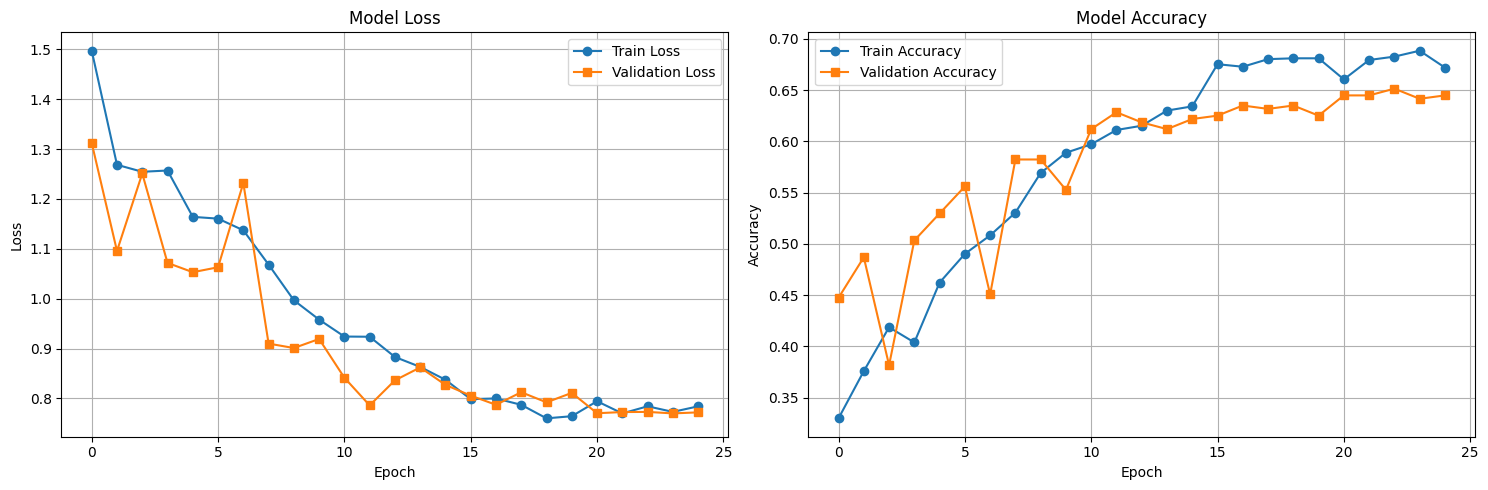

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


Test Accuracy: 33.86%
Test Loss: 1.8502

Classification Report:
              precision    recall  f1-score   support

         HGC       0.53      0.23      0.32        74
         LGC       0.04      0.02      0.03        53
         NST       0.39      0.68      0.50        37
         NTL       0.30      0.84      0.44        25

    accuracy                           0.34       189
   macro avg       0.32      0.44      0.32       189
weighted avg       0.34      0.34      0.29       189


Confusion Matrix:
[[17 22 29  6]
 [15  1  6 31]
 [ 0  0 25 12]
 [ 0  0  4 21]]

ROC-AUC Scores:
Macro-average AUC: 0.6917
Micro-average AUC: 0.6275
HGC AUC: 0.7489
LGC AUC: 0.4592
NST AUC: 0.7710
NTL AUC: 0.7876


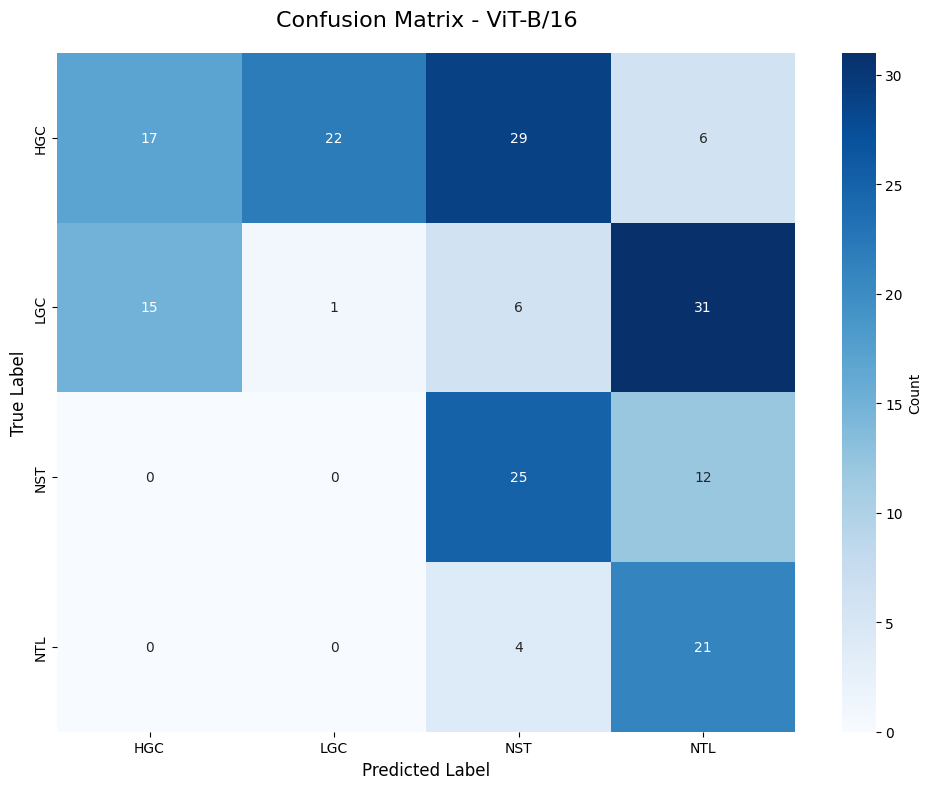

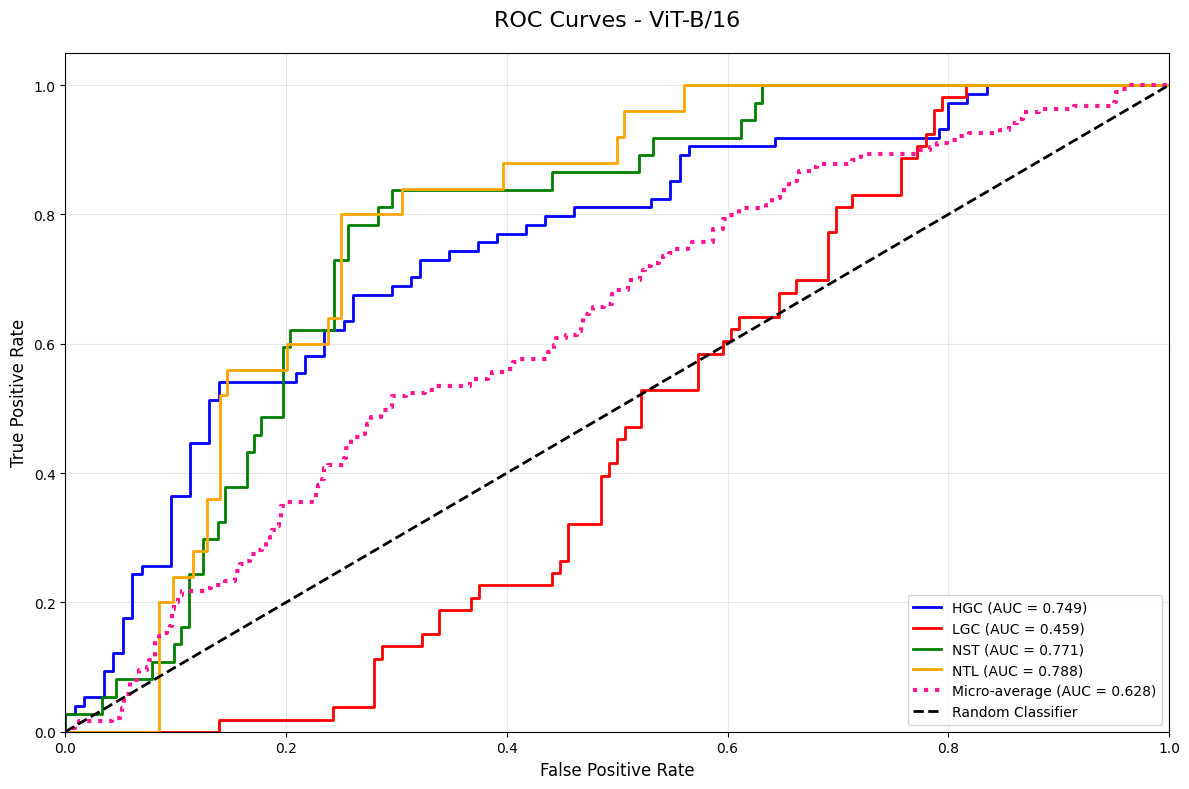


ViT-B/16 training and evaluation complete!


In [15]:
print("=" * 80)
print("Training Vision Transformer B/16")
print("=" * 80)

# Create model
vit_b16 = create_vit_model(num_classes=4, pretrained=True, model_type='b16')

# Create trainer
trainer_vit_b16 = ModelTrainer(vit_b16, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vit_b16 = trainer_vit_b16.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ViT-B16")

# Plot training history
trainer_vit_b16.plot_training_history(save_path='vit_b16_training_history.png')

# Evaluate model
results_vit_b16 = trainer_vit_b16.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vit_b16['confusion_matrix'], class_names, 'ViT-B/16',
                      save_path='vit_b16_confusion_matrix.png')

# Plot ROC curves
roc_auc_vit_b16 = plot_roc_curves(results_vit_b16['labels'], results_vit_b16['probabilities'], class_names, 'ViT-B/16',
                                   save_path='vit_b16_roc_curves.png')

# Store results
results_vit_b16['model_name'] = 'ViT-B/16'
results_vit_b16['roc_auc'] = roc_auc_vit_b16
all_results.append(results_vit_b16)

print("\nViT-B/16 training and evaluation complete!")

## Train ViT-B/32

Training Vision Transformer B/32


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


100%|██████████| 337M/337M [00:19<00:00, 18.1MB/s]


Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.05it/s, Loss=1.6042, Acc=0.2640]


Train Loss: 1.6042 Acc: 0.2640 Macro-F1: 0.2407


Val : 100%|██████████| 10/10 [00:01<00:00,  8.80it/s, Loss=1.7729, Acc=0.0724]


Val Loss: 1.7729 Acc: 0.0724 Macro-F1: 0.0337
✓ New best model saved with validation macro-F1: 0.0337

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.87it/s, Loss=1.4414, Acc=0.2541]


Train Loss: 1.4414 Acc: 0.2541 Macro-F1: 0.2374


Val : 100%|██████████| 10/10 [00:01<00:00,  8.22it/s, Loss=1.3436, Acc=0.3684]


Val Loss: 1.3436 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.98it/s, Loss=1.4197, Acc=0.2903]


Train Loss: 1.4197 Acc: 0.2903 Macro-F1: 0.2474


Val : 100%|██████████| 10/10 [00:01<00:00,  8.41it/s, Loss=1.2763, Acc=0.4638]


Val Loss: 1.2763 Acc: 0.4638 Macro-F1: 0.2804
✓ New best model saved with validation macro-F1: 0.2804

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.92it/s, Loss=1.4202, Acc=0.3709]


Train Loss: 1.4202 Acc: 0.3709 Macro-F1: 0.3092


Val : 100%|██████████| 10/10 [00:01<00:00,  8.67it/s, Loss=1.3646, Acc=0.4309]


Val Loss: 1.3646 Acc: 0.4309 Macro-F1: 0.3019
✓ New best model saved with validation macro-F1: 0.3019

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.97it/s, Loss=1.4275, Acc=0.3183]


Train Loss: 1.4275 Acc: 0.3183 Macro-F1: 0.2955


Val : 100%|██████████| 10/10 [00:01<00:00,  8.52it/s, Loss=1.2593, Acc=0.3750]


Val Loss: 1.2593 Acc: 0.3750 Macro-F1: 0.2719

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.96it/s, Loss=1.3178, Acc=0.3396]


Train Loss: 1.3178 Acc: 0.3396 Macro-F1: 0.3119


Val : 100%|██████████| 10/10 [00:01<00:00,  7.38it/s, Loss=1.2810, Acc=0.4112]


Val Loss: 1.2810 Acc: 0.4112 Macro-F1: 0.3384
✓ New best model saved with validation macro-F1: 0.3384

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.03it/s, Loss=1.3174, Acc=0.3495]


Train Loss: 1.3174 Acc: 0.3495 Macro-F1: 0.3296


Val : 100%|██████████| 10/10 [00:01<00:00,  7.83it/s, Loss=1.2799, Acc=0.4112]


Val Loss: 1.2799 Acc: 0.4112 Macro-F1: 0.3860
✓ New best model saved with validation macro-F1: 0.3860

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.02it/s, Loss=1.2258, Acc=0.4408]


Train Loss: 1.2258 Acc: 0.4408 Macro-F1: 0.4082


Val : 100%|██████████| 10/10 [00:01<00:00,  8.01it/s, Loss=1.1357, Acc=0.4868]


Val Loss: 1.1357 Acc: 0.4868 Macro-F1: 0.4407
✓ New best model saved with validation macro-F1: 0.4407

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.89it/s, Loss=1.2039, Acc=0.4350]


Train Loss: 1.2039 Acc: 0.4350 Macro-F1: 0.3997


Val : 100%|██████████| 10/10 [00:01<00:00,  7.91it/s, Loss=1.1561, Acc=0.4803]


Val Loss: 1.1561 Acc: 0.4803 Macro-F1: 0.4526
✓ New best model saved with validation macro-F1: 0.4526

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.89it/s, Loss=1.1968, Acc=0.4359]


Train Loss: 1.1968 Acc: 0.4359 Macro-F1: 0.4008


Val : 100%|██████████| 10/10 [00:01<00:00,  7.86it/s, Loss=1.1085, Acc=0.4901]


Val Loss: 1.1085 Acc: 0.4901 Macro-F1: 0.4339

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.90it/s, Loss=1.1915, Acc=0.4416]


Train Loss: 1.1915 Acc: 0.4416 Macro-F1: 0.4119


Val : 100%|██████████| 10/10 [00:01<00:00,  8.20it/s, Loss=1.1599, Acc=0.4408]


Val Loss: 1.1599 Acc: 0.4408 Macro-F1: 0.4344

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:08<00:00,  4.70it/s, Loss=1.1838, Acc=0.4490]


Train Loss: 1.1838 Acc: 0.4490 Macro-F1: 0.4148


Val : 100%|██████████| 10/10 [00:01<00:00,  8.98it/s, Loss=1.1224, Acc=0.4704]


Val Loss: 1.1224 Acc: 0.4704 Macro-F1: 0.4357

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  4.99it/s, Loss=1.1845, Acc=0.4383]


Train Loss: 1.1845 Acc: 0.4383 Macro-F1: 0.4100


Val : 100%|██████████| 10/10 [00:01<00:00,  8.88it/s, Loss=1.1177, Acc=0.4737]


Val Loss: 1.1177 Acc: 0.4737 Macro-F1: 0.4596
✓ New best model saved with validation macro-F1: 0.4596

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.04it/s, Loss=1.1769, Acc=0.4671]


Train Loss: 1.1769 Acc: 0.4671 Macro-F1: 0.4346


Val : 100%|██████████| 10/10 [00:01<00:00,  7.76it/s, Loss=1.1637, Acc=0.4441]


Val Loss: 1.1637 Acc: 0.4441 Macro-F1: 0.3879

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.10it/s, Loss=1.1808, Acc=0.4071]


Train Loss: 1.1808 Acc: 0.4071 Macro-F1: 0.3771


Val : 100%|██████████| 10/10 [00:01<00:00,  8.89it/s, Loss=1.1498, Acc=0.4671]


Val Loss: 1.1498 Acc: 0.4671 Macro-F1: 0.4364

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.05it/s, Loss=1.1825, Acc=0.4359]


Train Loss: 1.1825 Acc: 0.4359 Macro-F1: 0.4118


Val : 100%|██████████| 10/10 [00:01<00:00,  7.80it/s, Loss=1.1384, Acc=0.4539]


Val Loss: 1.1384 Acc: 0.4539 Macro-F1: 0.4332

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.05it/s, Loss=1.1899, Acc=0.4416]


Train Loss: 1.1899 Acc: 0.4416 Macro-F1: 0.4165


Val : 100%|██████████| 10/10 [00:01<00:00,  7.39it/s, Loss=1.1403, Acc=0.4572]


Val Loss: 1.1403 Acc: 0.4572 Macro-F1: 0.4401

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:07<00:00,  5.20it/s, Loss=1.1817, Acc=0.4457]


Train Loss: 1.1817 Acc: 0.4457 Macro-F1: 0.4184


Val : 100%|██████████| 10/10 [00:01<00:00,  8.88it/s, Loss=1.1319, Acc=0.4474]


Val Loss: 1.1319 Acc: 0.4474 Macro-F1: 0.4331
Early stopping triggered after 18 epochs
Training complete in 2m 45s
Best validation macro-F1: 0.4596


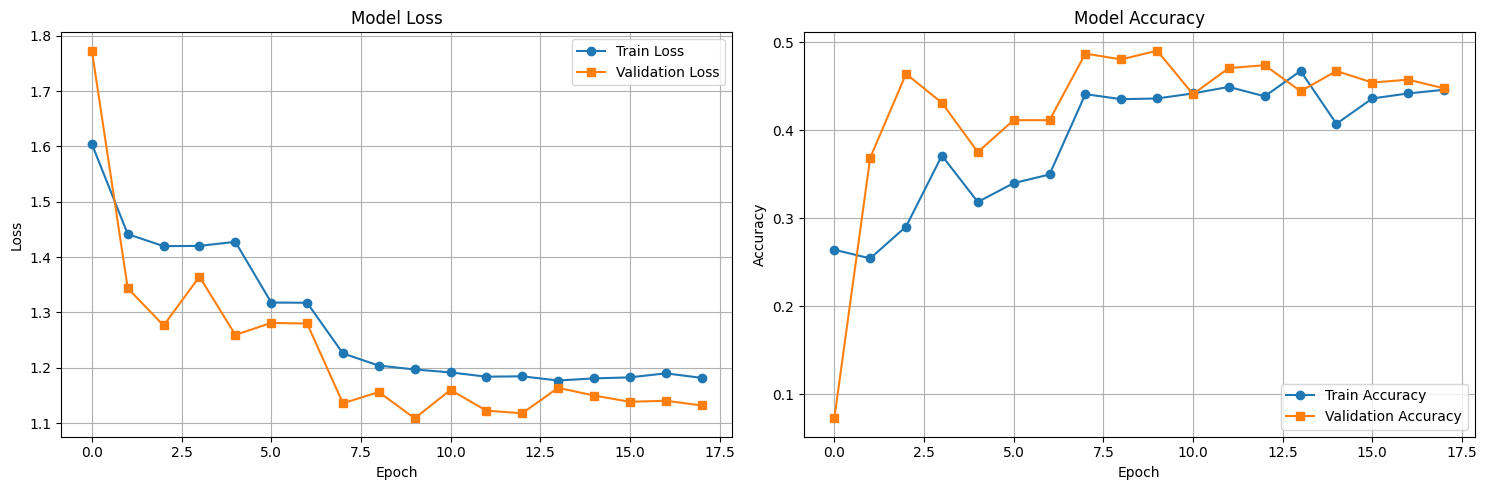

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  5.93it/s]


Test Accuracy: 27.51%
Test Loss: 1.5924

Classification Report:
              precision    recall  f1-score   support

         HGC       0.36      0.07      0.11        74
         LGC       0.70      0.36      0.47        53
         NST       0.12      0.16      0.14        37
         NTL       0.23      0.88      0.36        25

    accuracy                           0.28       189
   macro avg       0.35      0.37      0.27       189
weighted avg       0.39      0.28      0.25       189


Confusion Matrix:
[[ 5  8 41 20]
 [ 9 19  1 24]
 [ 0  0  6 31]
 [ 0  0  3 22]]

ROC-AUC Scores:
Macro-average AUC: 0.6381
Micro-average AUC: 0.5463
HGC AUC: 0.5377
LGC AUC: 0.7748
NST AUC: 0.5587
NTL AUC: 0.6810


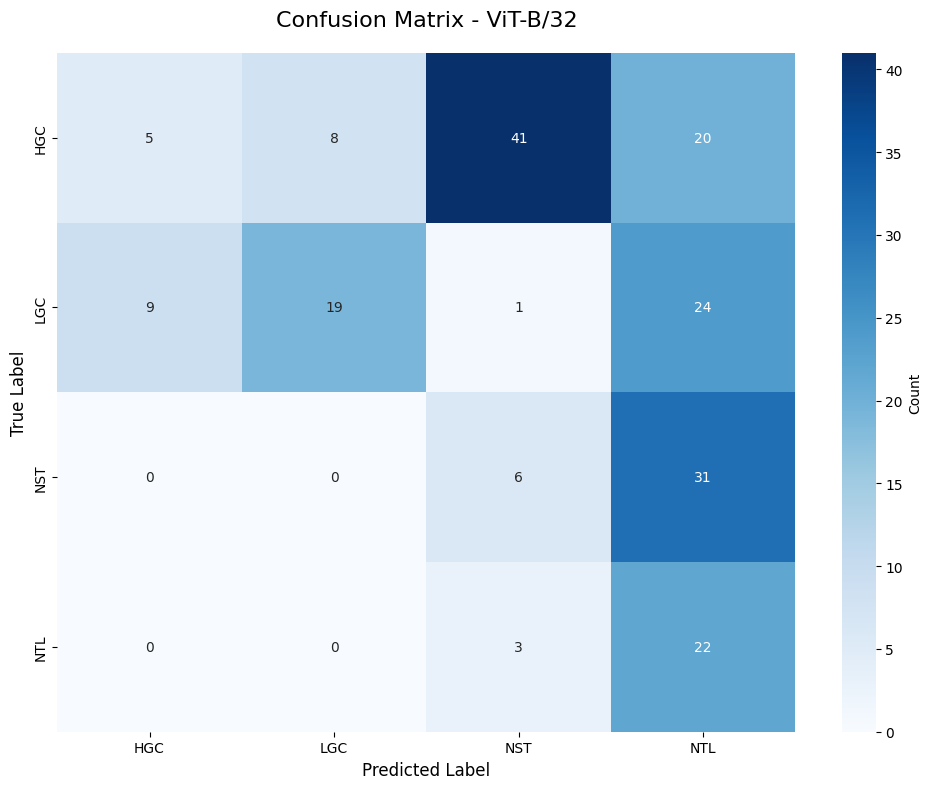

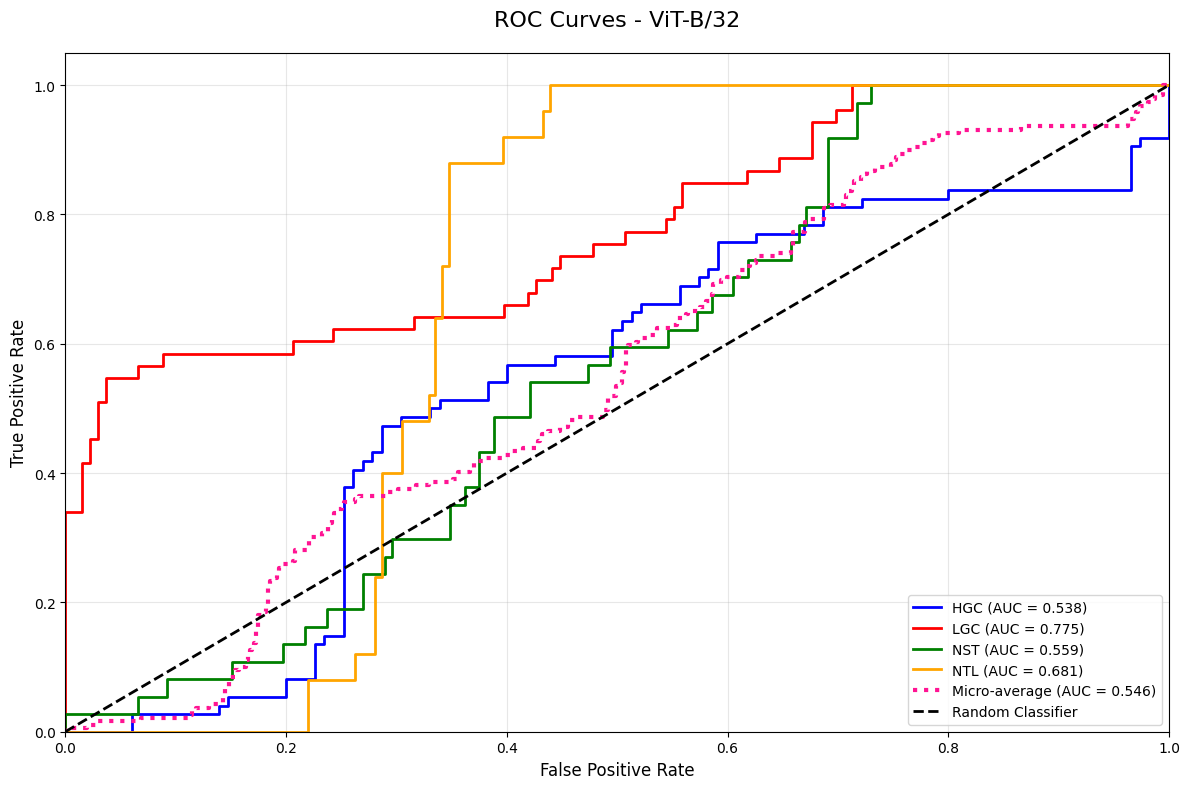


ViT-B/32 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training Vision Transformer B/32")
print("=" * 80)

# Create model
vit_b32 = create_vit_model(num_classes=4, pretrained=True, model_type='b32')

# Create trainer
trainer_vit_b32 = ModelTrainer(vit_b32, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_vit_b32 = trainer_vit_b32.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ViT-B32")

# Plot training history
trainer_vit_b32.plot_training_history(save_path='vit_b32_training_history.png')

# Evaluate model
results_vit_b32 = trainer_vit_b32.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_vit_b32['confusion_matrix'], class_names, 'ViT-B/32',
                      save_path='vit_b32_confusion_matrix.png')

# Plot ROC curves
roc_auc_vit_b32 = plot_roc_curves(results_vit_b32['labels'], results_vit_b32['probabilities'], class_names, 'ViT-B/32',
                                   save_path='vit_b32_roc_curves.png')

# Store results
results_vit_b32['model_name'] = 'ViT-B/32'
results_vit_b32['roc_auc'] = roc_auc_vit_b32
all_results.append(results_vit_b32)

print("\nViT-B/32 training and evaluation complete!")

# Save All Metrics to CSV

In [17]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'ViT_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: ViT_metrics.csv

Metrics Summary:
      Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0  ViT-B/16         33.862434      1.850152             0.316338          0.441068      0.321056                0.336349             0.338624         0.288360       0.531250    0.229730  0.320755         74.0       0.043478    0.018868  0.026316         53.0       0.390625    0.675676  0.495050         37.0       0.300000        0.84  0.442105         25.0   0.691660   0.627521  0.748884  0.459212  0.770982  0.787561      0.748884      0.459212  